In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

if 'thesis.Aircraft' in sys.modules: del sys.modules['thesis.Aircraft']
from thesis.Aircraft import Aircraft

if 'thesis.Flight' in sys.modules: del sys.modules['thesis.Flight']
from thesis.Flight import Flight

# Just some figuring out how heavy we are
# https://www.doubleradius.com/site/stores/baicells/baicells-nova-233-gen-2-enodeb-outdoor-base-station-datasheet.pdf
# Unsure how massive antenna are, guessing 1 kg
# Potentially unreliable sources say that the Starlink terminal is about 12 Ibs (https://www.reddit.com/r/Starlink/comments/jqck07/how_much_does_dishy_weigh/)
m_payload = 4.4 + 1 + 6  # kg
# Starlink power figure https://arstechnica.com/information-technology/2020/11/spacex-starlink-beta-tester-takes-user-terminal-into-forest-gets-120mbps/
# This figure may be overstated as it is for that users "whole system" (router, other equipment included?)
# Others say 50-100 W https://www.reddit.com/r/Starlink/comments/kf8ajt/power_consumption_of_starlink/
# We compromise here with 80
P_payload = 45 + 80       # W

# Main contributor to performance, both from an efficiency and solar area perspective
# Estimating 8-24 m is sufficient (summer vs winter at 45 N latitude)
# Zephyr 7 (22.5 m span) is around 50 kg, which we are estimating
wingSpan = 21 # m
wingChord = wingSpan / 20.5 # m
wingArea = wingSpan * wingChord # m^2
solarFill = 0.85 # % of wing surface with solar PV
solarArea = wingArea * solarFill # Solar panel area m^2

P_solar_cap = 3000 # Maximum solar power in (W)
P_prop = 1500      # Maximum propellor power (W)

# Mostly taken from Oettershagen2017Design
m_struct = 50.16

# TODO for final version take data points from Oettershaggen paper and HAPSMobile to interpolate/verify these values

m_prop = 0.0011 * P_prop
m_solar = 0.59 * solarArea
m_mppt = 0.422 * 0.422e-3 * P_solar_cap
m_av = 1.22
bat_Wh_cap = 15.5 * 650
# From Oettershagen
#m_bat = bat_Wh_cap / 251
# From hypothetical Licerion/Sionpower Lithium-metal cells
m_bat = bat_Wh_cap / 650

mass = m_struct + m_prop + m_solar + m_mppt + m_av + m_payload + m_bat
print('Mass is %.2f kg (%.2f kg struct, %.2f kg bat)' % (mass, m_struct, m_bat))

# From NS3 defaults
radioParams = {
    'xmitPower': 30, # dBm
    'B': 180e3 * 25, # 25 180kHz RBs = 4.5 MHz
    'N0': -174       # See lte-spectrum-value-helper.cc kT_dBm_Hz
}

craft = Aircraft(mass = mass, wingSpan = wingSpan, e0 = 0.92, chord = wingChord)

print('For runner.py')
print('='*80)
print('mass, wingSpan, e0, chord, bat_Wh_cap = %.2f, %.2f, %.2f, %.2f, %.2f' % (mass, wingSpan, 0.92, wingChord, bat_Wh_cap))

Mass is 91.25 kg (50.16 kg struct, 15.50 kg bat)
For runner.py
mass, wingSpan, e0, chord, bat_Wh_cap = 91.25, 21.00, 0.92, 1.02, 10075.00


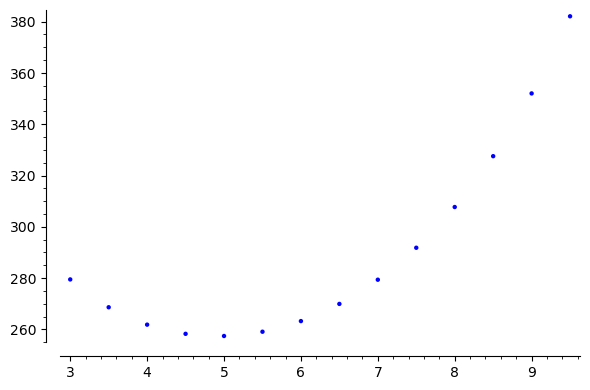

[10.1891036328800, 25.2676083713822, 257.454280251040]

In [21]:
show(list_plot([
    (i, craft.fastStraightVelocityThrustPower(0, i, 0, 1000)[2].n())
    for i in np.arange(3, 10, 0.5)
]))
[n(v) for v in craft.fastStraightVelocityThrustPower(0, 5, 0, 1000)]

In [22]:
if 'thesis.EvalHelper' in sys.modules: del sys.modules['thesis.EvalHelper']
if 'thesis.Scenario' in sys.modules: del sys.modules['thesis.Scenario']

from thesis.EvalHelper import Judge
from thesis.Scenario import Scenario

scene = Scenario()
scene.addRandomGroundUsersUniformCircular(2, r = 5000)

judge = Judge(scene, craft)

scene.render(size=50000)

Graphics3d Object

 Flight Info
3079 Second cycles, for 28 cycles with 174 left over
2020-07-01 00:51:00-04:00
altitude min=1000 mean=1000 max=1000


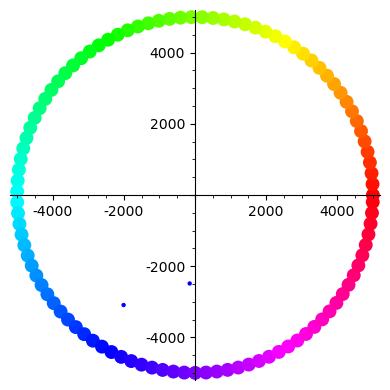



 Power info
2020-12-03 08:00:00-05:00
mSoc = 39.62%




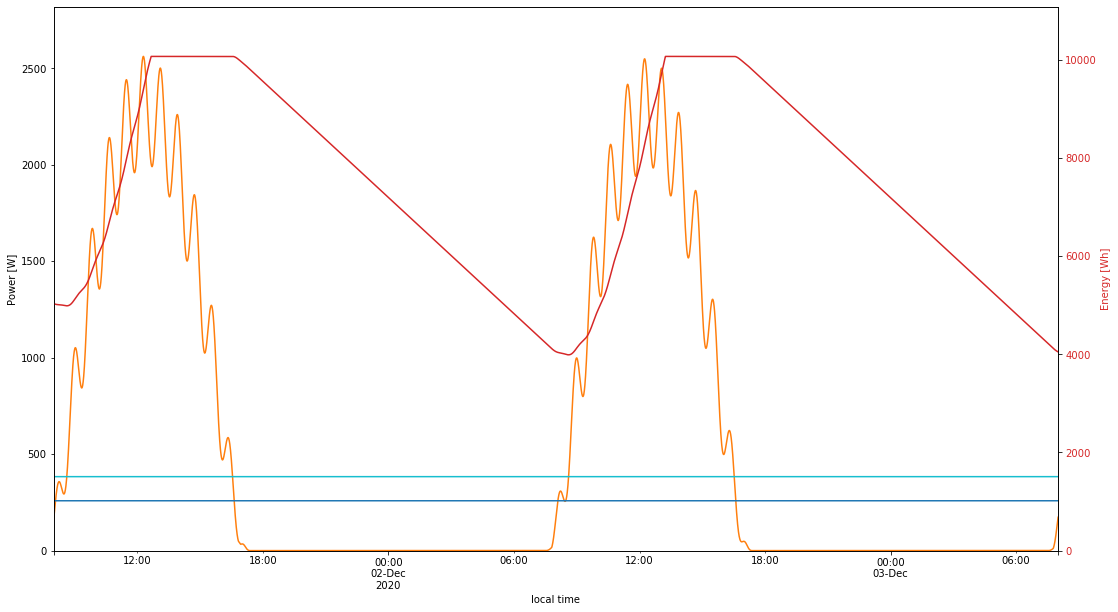

In [25]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import CircleTrajectory
# Basically level flight
trajectory = CircleTrajectory((0, 0, 1000), 5000)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-12-01T08', end = '2020-12-03T08')